In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import time

from game_risk import Game
from players.guesser import *
from players.codemaster import *
from utils.import_string_to_class import import_string_to_class

In [ ]:
# STATES
# Nb of red cards remaining = range(0, 9, 1) -> 9 possibilities
# Nb of blue cards remaining = range(0, 8, 1) -> 8 possibilities
# Nb of grey cards remaining = range(0, 10, 1) -> 10 possibilities
# Mean nb of words guessed / turn = range(0, 4, 0.2) -> 20 possibilities ??
# Ratio of good guesses = range(0, 1, 0.01) -> 100 possibilities

# ACTIONS
# risk threshold = range(0, 1, 0.1) -> 10 possibilities

# Path to models
codemaster_model = 'players.codemaster_glove_rl.AICodemaster'
guesser_model = 'players.guesser_w2v.AIGuesser'
w2v = 'players/GoogleNews-vectors-negative300.bin'
wordnet = None
glove = 'players/glove.6B.300d.txt'

In [ ]:
# Define our network
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Global parameters
GAMMA = 0.99
BATCH_SIZE = 4
UPDATE_TARGET_EVERY = 32
EPSILON_START = 1.0
DECREASE_EPSILON = 200
EPSILON_MIN = 0.05
N_EPISODES = 100
LEARNING_RATE = 0.1
BUFFER_CAPACITY = 10000
EVAL_EVERY = 5
REWARD_THRESHOLD = 1000

In [ ]:
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor([states])
        output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

def choose_action(state, epsilon):
    """
    Return action according to an epsilon-greedy exploration policy
    """
    q_values = get_q([state])
    
    if random.random() < epsilon:
        return random.randint(0, n_actions-1) # env.action_space.sample()
    else:
        return np.argmax(q_values[0])


def update(state, action, reward, next_state, done, BATCH_SIZE, GAMMA):
    """
    ** TO BE COMPLETED **
    """
    
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)
    
    if len(replay_buffer) < BATCH_SIZE:
        return np.inf
    
    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)
    
    # Compute loss - TO BE IMPLEMENTED!
    states = torch.FloatTensor([transition[0] for transition in transitions])
    actions = torch.LongTensor([[transition[1]] for transition in transitions])
    
    values = q_net.forward(states).gather(1, actions)

    rewards = torch.FloatTensor([[transition[2]] for transition in transitions])
    next_states = torch.FloatTensor([np.zeros(obs_size) if transition[3] is None else transition[3] for transition in transitions])
    none_filter = torch.FloatTensor([[0.0] if transition[3] is None else [1.0] for transition in transitions])

    targets = torch.max(target_net.forward(next_states), 1, keepdim=True).values
    targets = rewards + GAMMA * targets * none_filter
    
    loss = objective(values, targets)
     
    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

In [ ]:
def train(GAMMA=0.99, 
          EPSILON_START = 1.0, 
          N_EPISODES = 100,
          BATCH_SIZE = 4, 
          UPDATE_TARGET_EVERY = 32, 
          EPSILON_MIN = 0.05, 
          DECREASE_EPSILON = 200
          ):

    nb_win, nb_turns = 0, [] 

    print('Beginning training')
    print('Loading models...')

    codemaster = import_string_to_class(codemaster_model)
    guesser = import_string_to_class(guesser_model)
    g_kwargs = {}
    cm_kwargs = {}
    if wordnet is not None:
        brown_ic = Game.load_wordnet(wordnet)
        g_kwargs["brown_ic"] = brown_ic
        cm_kwargs["brown_ic"] = brown_ic
    if glove is not None:
        glove_vectors = Game.load_glove_vecs(glove)
        g_kwargs["glove_vecs"] = glove_vectors
        cm_kwargs["glove_vecs"] = glove_vectors
    if w2v is not None:
        w2v_vectors = Game.load_w2v(w2v)
        g_kwargs["word_vectors"] = w2v_vectors
        cm_kwargs["word_vectors"] = w2v_vectors

    print('Models imported')

    nb_guesses = 0
    nb_good_guesses = 0

    state = [8, 7, 9, 0]
    epsilon = EPSILON_START
    ep = 0
    total_time = 0

    game = Game(codemaster,
            guesser,
            seed='time',
            do_print=False,
            do_log=False,
            game_name='train_risk_rl',
            cm_kwargs=cm_kwargs,
            g_kwargs=g_kwargs,
            nb_guesses=nb_guesses,
            nb_good_guesses=nb_good_guesses,
            display_board=False)

    while ep < N_EPISODES:
        print(f"Episode {ep}")
        action = choose_action(state, epsilon)

        # take action
        next_state, reward, done = game.step(action)
        loss = update(state, action, reward, next_state, done, BATCH_SIZE, GAMMA)

        # update state
        state = next_state

        # end episode if done
        if done:
            
            # Update returned values
            if game.game_counter != 25:
                nb_win +=1
            nb_turns.append(game.game_counter)


            nb_guesses, nb_good_guesses = game.get_guesses()
            game = Game(codemaster,
                guesser,
                seed='time',
                do_print=False,
                do_log=False,
                game_name='train_risk_rl',
                cm_kwargs=cm_kwargs,
                g_kwargs=g_kwargs,
                nb_guesses=nb_guesses,
                nb_good_guesses=nb_good_guesses,
                display_board=False)
            ratio = np.round(nb_good_guesses / nb_guesses, 2)
            state = [8, 7, 9, ratio]
            ep   += 1

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )   

        total_time += 1

    return nb_win, nb_turns

# Test avec variables quelconques

In [ ]:
# create network and target network
hidden_size = 128
obs_size = 4
n_actions = 10

q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

In [29]:
nb_win, nb_turns = train()




The clue is: karl 1
karl
['*Red*', 'BELL', 'LION', 'BLOCK', '*Red*', '*Red*', '*Blue*', 'PUPIL', 'ROBOT', '*Blue*', 'DANCE', '*Blue*', 'CONDUCTOR', '*Red*', 'SERVER', 'BUTTON', '*Red*', 'CRICKET', '*Red*', 'HORSESHOE', '*Civilian*', '*Red*', 'ARM', '*Civilian*', 'ROCK']
guesses: [(0.855104848742485, 'BUTTON'), (0.8888088464736938, 'ROBOT'), (0.8908905610442162, 'LION'), (0.8985746800899506, 'HORSESHOE'), (0.9049765467643738, 'SERVER'), (0.912466511130333, 'CRICKET'), (0.9207732453942299, 'BELL'), (0.9264679849147797, 'BLOCK'), (0.9473465532064438, 'PUPIL'), (0.9532577060163021, 'ROCK'), (0.9888002704828978, 'DANCE'), (0.9980663097230718, 'CONDUCTOR'), (1.0422867462038994, 'ARM')]
Episode 13



RED:	 ['conductor']
BESTS:  {1: (('conductor',), 'karl', 0.7524370880862429), 2: ('', '', inf), 3: ('', '', inf)}
0.7524370880862429 (('conductor',), 'karl', 0.7524370880862429) 1
chosen_clue is: (('conductor',), 'karl', 0.7524370880862429)



The clue is: karl 1
karl
['*Red*', 'BELL', 'LION',

In [30]:
print(f"Percentage of win : {nb_win/len(nb_turns)}")
print(f"Average number of turns : {np.mean(nb_turns)}")

Percentage of win : 0.6
Average number of turns : 15.48


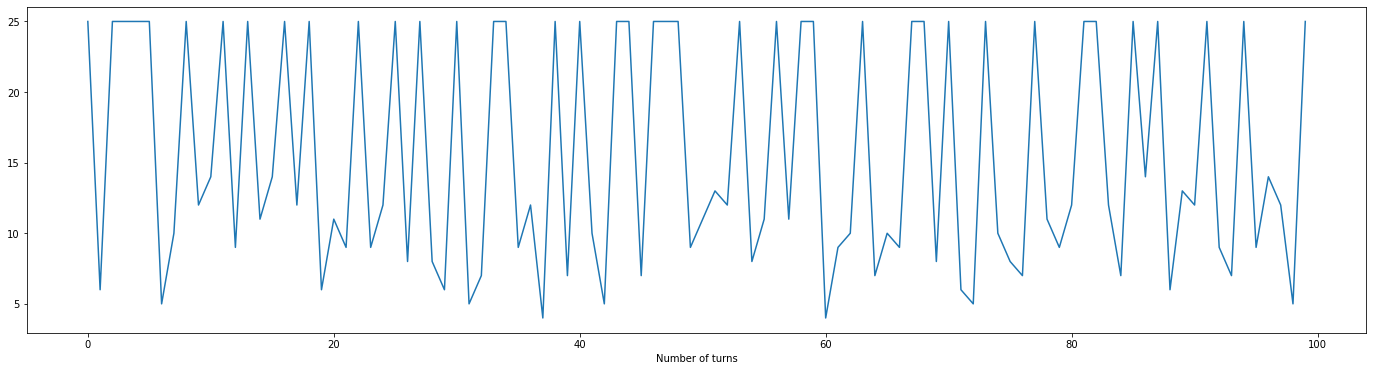

In [31]:
plt.figure(figsize = (24, 6))
plt.xlabel("Number of turns")
plt.ylabel("")
plt.plot(range(len(nb_turns)), nb_turns)


In [32]:
mean_nb_turn = []
for i in range(len(nb_turns)):
    mean_nb_turn.append(np.mean(nb_turns[:i]))

/opt/homebrew/Caskroom/miniforge/base/envs/codenames/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/codenames/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


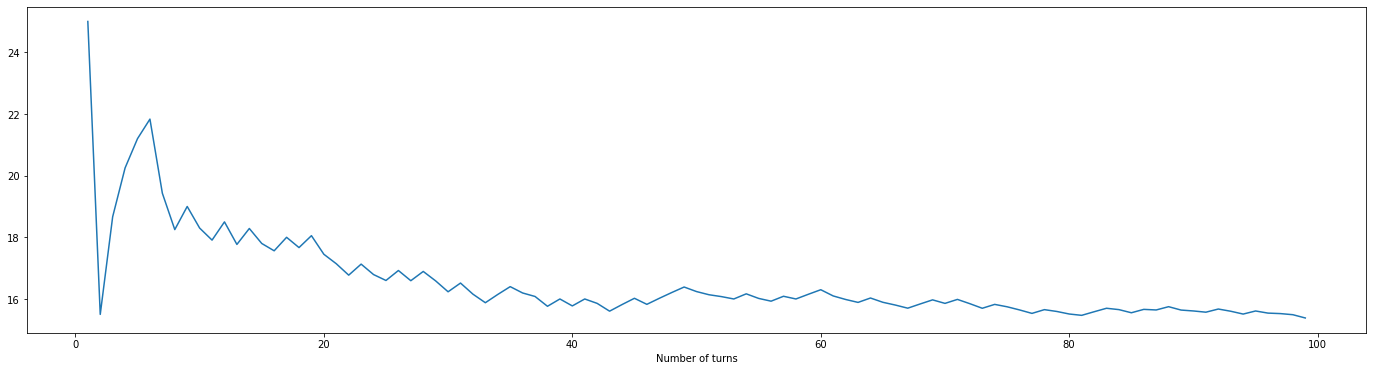

In [33]:
plt.figure(figsize = (24, 6))
plt.xlabel("Number of turns")
plt.ylabel("")
plt.plot(range(len(mean_nb_turn)), mean_nb_turn)

# Influence BUFFER_CAPACITY

In [34]:
BUFFER_CAPACITY_VALUES = [2**i for i in range(15)]
nb_win_list = []
average_nb_turn = []

for value in BUFFER_CAPACITY_VALUES:

    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)

    # objective and optimizer
    objective = nn.MSELoss()
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

    # create instance of replay buffer
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    nb_wins, nb_turns = train()
    nb_win_list.append(nb_win)
    average_nb_turn.append(np.mean(nb_turns))

Beginning training
Loading models...
Models imported
Episode 1



RED:	 ['horseshoe', 'root', 'lion', 'buffalo', 'center', 'london', 'knife', 'tooth']
BESTS:  {1: (('lion',), 'bear', 0.515232885718452), 2: (('center', 'london'), 'main', 0.7002816407240974), 3: (('lion', 'buffalo', 'tooth'), 'bear', 0.7904739654538537)}
0.515232885718452 (('lion',), 'bear', 0.515232885718452) 1
0.7002816407240974 (('lion',), 'bear', 0.515232885718452) 1
0.7904739654538537 (('center', 'london'), 'main', 0.7002816407240974) 2
chosen_clue is: (('lion', 'buffalo', 'tooth'), 'bear', 0.7904739654538537)



The clue is: bear 3
bear
['CRICKET', 'HORSESHOE', 'ROOT', 'LION', 'DANCE', 'SPY', 'BUFFALO', 'PLATYPUS', 'CENTER', 'LONDON', 'BOTTLE', 'BED', 'AIR', 'STRIKE', 'WAR', 'BELL', 'SCORPION', 'PARACHUTE', 'BOX', 'ROCK', 'KETCHUP', 'KNIFE', 'ROME', 'TOOTH', 'PUPIL']
guesses: [(0.5554157495498657, 'LION'), (0.7341909110546112, 'BUFFALO'), (0.7663472443819046, 'SCORPION'), (0.7911405265331268, 'PLATYPUS'), (0.824760

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 6)) 
ax1.plot(BUFFER_CAPACITY_VALUES, nb_win_list)
ax1.set_xlabel('Buffer Capacity')
ax1.set_ylabel('Number of wins')
ax1.set_xscale('log', base = 2)

ax2.plot(BUFFER_CAPACITY_VALUES, average_nb_turn)
ax2.set_xlabel('Buffer Capacity')
ax2.set_ylabel('Average # of turns')
ax2.set_xscale('log', base = 2)

# Influence UPDATE_TARGET_EVERY

In [ ]:
UPDATE_TARGET_EVERY_VALUES = [2*i+1 for i in range(30)]
nb_win_list = []
average_nb_turn = []

for value in UPDATE_TARGET_EVERY_VALUES:

    q_net = Net(obs_size, hidden_size, n_actions)
    target_net = Net(obs_size, hidden_size, n_actions)

    # objective and optimizer
    objective = nn.MSELoss()
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

    # create instance of replay buffer
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    nb_wins, nb_turns = train(UPDATE_TARGET_EVERY=value)
    nb_win_list.append(nb_win)
    average_nb_turn.append(np.mean(nb_turns))

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 6)) 
ax1.plot(UPDATE_TARGET_EVERY_VALUES, nb_win_list)
ax1.set_xlabel('Update frequency')
ax1.set_ylabel('Number of wins')
ax1.set_xscale('log', base = 2)

ax2.plot(UPDATE_TARGET_EVERY_VALUES, average_nb_turn)
ax2.set_xlabel('Update frequency')
ax2.set_ylabel('Average # of turns')
ax2.set_xscale('log', base = 2)